In [14]:
LOAD = True

In [17]:
if LOAD !=True: from classy import Class
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
green1='#238E68'
green2='#32CC99' 
green3='#76EEC6'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
import swyft
from copy import deepcopy

In [19]:
from getdist import plots, MCSamples
import getdist

some imports for plotting functions

In [20]:
import os
import copy
import matplotlib
import sys
import warnings
import logging
from types import MappingProxyType
from typing import Mapping, Sequence, Union

if 'ipykern' not in matplotlib.rcParams['backend'] and \
        'linux' in sys.platform and os.environ.get('DISPLAY', '') == '':
    # default to agg if not in notebook and linux with no display
    matplotlib.use('Agg')

import matplotlib.patches
import matplotlib.colors
import matplotlib.gridspec
import matplotlib.axis
import matplotlib.lines
from matplotlib import cm, rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.font_manager import font_scalings
import numpy as np
import getdist
from getdist import MCSamples, loadMCSamples, ParamNames, ParamInfo, IniFile
from getdist.chain_grid import is_grid_object, get_chain_root_files, ChainDirGrid, load_supported_grid
from getdist.chains import findChainFileRoot
from getdist.paramnames import escapeLatex, makeList, mergeRenames
from getdist.densities import Density2D
from getdist.gaussian_mixtures import MixtureND
from getdist.matplotlib_ext import BoundedMaxNLocator, SciFuncFormatter
from getdist._base import _BaseObject

In [21]:
'''plotting routine to use getdist with swyft'''
def triangle_plot(self, roots,weights=None, params=None, legend_labels=None, plot_3d_with_param=None, filled=False, shaded=False,
                      contour_args=None, contour_colors=None, contour_ls=None, contour_lws=None, line_args=None,
                      label_order=None, legend_ncol=None, legend_loc=None, title_limit=None, upper_roots=None,
                      upper_kwargs={}, upper_label_right=False, diag1d_kwargs={}, markers=None,
                      marker_args={}, param_limits={}, **kwargs):
        
        roots = makeList(roots)
        params = self.get_param_array(roots[0], params)
        plot_col = len(params)
        if plot_3d_with_param is not None:
            col_param = self._check_param(roots[0], plot_3d_with_param)
        self.make_figure(nx=plot_col, ny=plot_col, sharex=self.settings.no_triangle_axis_labels,
                         sharey=self.settings.no_triangle_axis_labels)
        lims = dict()
        if kwargs.pop('filled_compare', False):
            filled = True

        def _axis_y_limit_changed(_ax):
            _lims = _ax.get_ylim()
            other = _ax._shared_x_axis
            if _lims != other.get_xlim():
                other.set_xlim(_lims)

        def _axis_x_limit_changed(_ax):
            _lims = _ax.get_xlim()
            other = _ax._shared_y_axis
            if _lims != other.get_ylim():
                other.set_ylim(_lims)

        def def_line_args(cont_args, cont_colors):
            cols = []
            for plotno, _arg in enumerate(cont_args):
                if not _arg.get('filled'):
                    if cont_colors is not None and len(cont_colors) > plotno:
                        cols.append(cont_colors[plotno])
                    else:
                        cols.append(None)
                else:
                    cols.append(_arg.get('color') or self._get_color_at_index(self.settings.solid_colors,
                                                                              len(cont_args) - plotno - 1))
            _line_args = []
            for col in cols:
                if col is None:
                    _line_args.append({})
                else:
                    if isinstance(col, (tuple, list)) and not matplotlib.colors.is_color_like(col):
                        col = col[-1]
                    _line_args += [{'color': col}]
            return _line_args

        if upper_roots is not None:
            if plot_3d_with_param is not None:
                logging.warning("triangle_plot upper_roots currently doesn't work with plot_3d_with_param")
            upper_contour_args = self._make_contour_args(len(upper_roots), filled=upper_kwargs.get('filled', filled),
                                                         contour_args=upper_kwargs.get('contour_args', contour_args),
                                                         colors=upper_kwargs.get('contour_colors', contour_colors),
                                                         ls=upper_kwargs.get('contour_ls', contour_ls),
                                                         lws=upper_kwargs.get('contour_lws', contour_lws))
            upper_line_args = upper_kwargs.get('line_args') or def_line_args(upper_contour_args,
                                                                             upper_kwargs.get('contour_colors',
                                                                                              contour_colors))
            upargs = self._make_line_args(len(upper_roots), line_args=upper_line_args,
                                          ls=upper_kwargs.get('contour_ls', contour_ls),
                                          lws=upper_kwargs.get('contour_lws', contour_lws))

        contour_args = self._make_contour_args(len(roots), filled=filled, contour_args=contour_args,
                                               colors=contour_colors, ls=contour_ls, lws=contour_lws)
        if line_args is None:
            line_args = def_line_args(contour_args, contour_colors)
        line_args = self._make_line_args(len(roots), line_args=line_args, ls=contour_ls, lws=contour_lws)
        roots1d = copy.copy(roots)
        if upper_roots is not None:
            show_1d = upper_kwargs.get('show_1d', True)
            if isinstance(show_1d, bool):
                show_1d = [show_1d] * len(upargs)
            for root, arg, show in zip(upper_roots, upargs, show_1d):
                if show and root not in roots1d:
                    roots1d.append(root)
                    line_args.append(arg)

        bottom = len(params) - 1
        for i, param in enumerate(params):
            for i2 in range(bottom, i, -1):
                self._subplot(i, i2, pars=(param, params[i2]),
                              sharex=self.subplots[bottom, i] if i2 != bottom else None,
                              sharey=self.subplots[i2, 0] if i > 0 else None)

            ax = self._subplot(i, i, pars=(param,), sharex=self.subplots[bottom, i] if i != bottom else None)
            marker = self._get_marker(markers, i, param.name)
            self._inner_ticks(ax, False)
            xlim = self.plot_1d(roots1d+[MCSamples(samples=samples['params'], names=names,
                                                    weights=samples['weights'][(i,)])],#,settings={'mult_bias_correction_order':0})],
                                                    #weights=samples['weights'][(0,1,2,3,4,5)])],
                                param, marker=marker, do_xlabel=i == plot_col - 1,
                                no_label_no_numbers=self.settings.no_triangle_axis_labels, title_limit=title_limit,
                                label_right=True, no_zero=True, no_ylabel=True, no_ytick=True, line_args=line_args,
                                lims=param_limits.get(param.name), ax=ax, _ret_range=True, **diag1d_kwargs)
            lims[i] = xlim
            if i > 0:
                ax._shared_y_axis = self.subplots[i, 0]
                ax.callbacks.connect('xlim_changed', _axis_x_limit_changed)

        if upper_roots is not None:
            if not upper_label_right:
                # make label on first 1D plot appropriate for 2D plots in rest of row
                label_ax = self.subplots[0, 0].twinx()
                self._inner_ticks(label_ax)
                label_ax.yaxis.tick_left()
                label_ax.yaxis.set_label_position('left')
                label_ax.yaxis.set_offset_position('left')
                label_ax.set_ylim(lims[0])
                self.set_ylabel(params[0], ax=label_ax)
                self._set_main_axis_properties(label_ax.yaxis, False)
                self.subplots[0, 0].yaxis.set_visible(False)
            else:
                label_ax = self.subplots[0, bottom]

            for y, param in enumerate(params[:-1]):
                for x in range(bottom, y, -1):
                    if y > 0:
                        share = self.subplots[y, 0]
                    else:
                        share = label_ax if (y < bottom or not upper_label_right) else None
                    self._subplot(x, y, pars=(params[x], param), sharex=self.subplots[bottom, x], sharey=share)

        for i, param in enumerate(params):
            marker = self._get_marker(markers, i, param.name)
            for i2 in range(i + 1, len(params)):
                param2 = params[i2]
                pair = [param, param2]
                marker2 = self._get_marker(markers, i2, param2.name)
                ax = self.subplots[i2, i]
                if plot_3d_with_param is not None:
                    self.plot_3d(roots, pair + [col_param], color_bar=False, line_offset=1, add_legend_proxy=False,
                                 do_xlabel=i2 == plot_col - 1, do_ylabel=i == 0, contour_args=contour_args,
                                 no_label_no_numbers=self.settings.no_triangle_axis_labels, ax=ax, **kwargs)
                else:
                    self.plot_2d(roots+[MCSamples(samples=samples['params'], names=names,
                                                    weights=samples['weights'][(i,i2)])],#,settings={'mult_bias_correction_order':0})],
                                                     #weights=samples['weights'][(0,1,2,3,4,5)])],
                                 param_pair=pair, do_xlabel=i2 == plot_col - 1, do_ylabel=i == 0,
                                 no_label_no_numbers=self.settings.no_triangle_axis_labels, shaded=shaded,
                                 add_legend_proxy=i == 0 and i2 == 1, contour_args=contour_args, ax=ax, **kwargs)
                if marker is not None:
                    self.add_x_marker(marker, ax=ax, **marker_args)
                if marker2 is not None:
                    self.add_y_marker(marker2, ax=ax, **marker_args)
                self._inner_ticks(ax)
                if i != i2:
                    ax.set_ylim(lims[i2])

                ax._shared_x_axis = self.subplots[bottom, i2]
                ax.callbacks.connect('ylim_changed', _axis_y_limit_changed)

                if i2 == bottom:
                    ax.set_xlim(lims[i])
                if i > 0:
                    ax._shared_y_axis = self.subplots[i, 0]
                    ax.callbacks.connect('xlim_changed', _axis_x_limit_changed)

                if upper_roots is not None:
                    if i == 0:
                        ax._shared_y_axis = label_ax
                        ax.callbacks.connect('xlim_changed', _axis_x_limit_changed)

                    ax = self.subplots[i, i2]
                    pair.reverse()
                    if plot_3d_with_param is not None:
                        self.plot_3d(upper_roots, pair + [col_param], color_bar=False, line_offset=1,
                                     add_legend_proxy=False, ax=ax, do_xlabel=False,
                                     do_ylabel=upper_label_right and i2 == bottom, contour_args=upper_contour_args,
                                     no_label_no_numbers=self.settings.no_triangle_axis_labels)
                    else:
                        self.plot_2d(upper_roots, param_pair=pair, do_xlabel=False,
                                     do_ylabel=upper_label_right and i2 == bottom,
                                     no_label_no_numbers=self.settings.no_triangle_axis_labels, shaded=shaded,
                                     add_legend_proxy=i == 0 and i2 == 1, ax=ax,
                                     proxy_root_exclude=[root for root in upper_roots if root in roots],
                                     contour_args=upper_contour_args)
                    if marker is not None:
                        self.add_y_marker(marker, ax=ax, **marker_args)
                    if marker2 is not None:
                        self.add_x_marker(marker2, ax=ax, **marker_args)
                    if upper_label_right and i2 == bottom:
                        ax.yaxis.set_label_position('right')
                        ax.yaxis.set_offset_position('right')
                        ax.yaxis.set_tick_params(which='both', labelright=True, labelleft=False)
                        self.set_ylabel(params[i], ax=ax, rotation=-90, va='bottom')

                    ax.set_xlim(lims[i2])
                    ax.set_ylim(lims[i])
                    ax._shared_x_axis = self.subplots[bottom, i]
                    ax.callbacks.connect('ylim_changed', _axis_y_limit_changed)
                    self._inner_ticks(ax)

        self._subplots_adjust()

        if plot_3d_with_param is not None:
            bottom = 0.5
            if len(params) == 2:
                bottom += 0.1
            cb = self.fig.colorbar(self.last_scatter, cax=self.fig.add_axes([0.9, bottom, 0.03, 0.35]))
            cb.ax.yaxis.set_ticks_position('left')
            cb.ax.yaxis.set_label_position('left')
            self.rotate_yticklabels(cb.ax, rotation=self.settings.colorbar_tick_rotation or 0,
                                    labelsize=self.settings.colorbar_axes_fontsize)
            self.add_colorbar_label(cb, col_param, label_rotation=-self.settings.colorbar_label_rotation)

        labels = self._default_legend_labels(legend_labels, roots1d)

        if not legend_loc and self.settings.figure_legend_loc == 'upper center' and \
                len(params) < 4 and upper_roots is None:
            legend_loc = 'upper right'
        else:
            legend_loc = legend_loc or self.settings.figure_legend_loc
        args = {}
        if 'upper' in legend_loc and upper_roots is None:
            args['bbox_to_anchor'] = (self.plot_col / (2 if 'center' in legend_loc else 1), 1)
            args['bbox_transform'] = self.subplots[0, 0].transAxes
            args['borderaxespad'] = 0

        self.finish_plot(labels, label_order=label_order,
                         legend_ncol=legend_ncol or self.settings.figure_legend_ncol or (
                             None if upper_roots is None else len(labels)), legend_loc=legend_loc,
                         no_extra_legend_space=upper_roots is None, no_tight=title_limit or self.settings.title_limit,
                         **args)

In [22]:
from getdist import loadMCSamples, plots

load MCMC results

In [67]:
sampMC=loadMCSamples('chains/2021-05-03_500000_')

In [68]:
sampMC2=loadMCSamples('chains/MCMC5000_',settings={'mult_bias_correction_order':0})#,'smooth_scale_2D':0.3, 'smooth_scale_1D':0.3})

In [69]:
sss= loadMCSamples('chains/2021-05-04_500000_',settings={'mult_bias_correction_order':0})

In [71]:
SSS=sampMC.getCombinedSamplesWithSamples(sss)

Removed no burn in


In [72]:
SSS.getNumSampleSummaryText()

'using 46925 rows, 6 parameters; mean weight 3.7632818327117743, tot weight 176592.0\nEquiv number of single samples (sum w)/max(w): 3098\nEffective number of weighted samples (sum w)^2/sum(w^2): 25935\n'

In [24]:
fpr2=np.loadtxt("noise_fake_planck_realistic_two.dat")

Define the simulator and noise model! The true noise model is a correlated $\chi^2$ (i.e. Wishart) distribution with $2\ell+1$ degrees of freedom. Since simulating this is expensive at large $\ell$, we use a Gaussian approximation starting at $\ell=51$. Note also that to call the noise model, it is efficient to sample the Gaussian noise ahead of time and store it in memory.

In [25]:
lmax=2500
fsky=0.6
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)
#detector contribution to signal, from file
Nltt=fpr2[ell-2,1]
Nlee=fpr2[ell-2,2]

def simulator(v,sigma=0.1):
    #to avoid some CosmoComputationErrors
    V=np.around(v, decimals=7)
    omega_b, omega_cdm, theta, lnAs,n_s,tau_reio=V[0],V[1],V[2],V[3],V[4],V[5]
    A_s=np.exp(lnAs)/ 1.e10
    params = {
        'output': 'tCl pCl lCl',
        'l_max_scalars': lmax,
        'lensing': 'yes',
        'omega_b': omega_b,
        'omega_cdm': omega_cdm,
        '100*theta_s': theta,
        #'ln10^{10}A_s': lnAs,
        'A_s': A_s,
        'n_s': n_s,
        'tau_reio': tau_reio
    }

    # Create an instance of the CLASS wrapper
    cosmo = Class()

    # Set the parameters to the cosmological code
    cosmo.set(params)

    # Run the code.
    cosmo.compute(['lensing'])
    # Extract observables.
    cls = cosmo.lensed_cl(lmax)
    T=cosmo.T_cmb()
    cosmo.struct_cleanup()
    return dict(TT=cls['tt'][ell]*(T*1.e6)**2+Nltt, TE=cls['te'][ell]*(T*1.e6)**2,\
            EE=cls['ee'][ell]*(T*1.e6)**2+Nlee)



#noise from cosmic variance
#before calling this function, need to generate noisevecs
def noise(obs, params=None, sigma=1.0):
    cat=np.concatenate((obs['TT'],obs['EE'],obs['TE']),axis=0)
    CLTT=[]
    CLEE=[]
    CLTE=[]
    #TODO: need to modify degrees at low ell of freedom using fsky
    for l in range(2,2+49):
    #for l in range(2,2501):
        #g1=np.random.randn(2*l+1)
        #g2=np.random.randn(2*l+1)
        #almT=np.sqrt(obs['TT'][l-2])*g1
        #almE=(obs['TE'][l-2]/np.sqrt(obs['TT'][l-2]))*g1+np.sqrt(obs['EE'][l-2]-obs['TE'][l-2]**2 / obs['TT'][l-2])*g2
        #print(almT.shape, almE.shape)
        #CLTT.append((((2*l+1))**-1 *np.sum((almT**2))))#*np.array([1]+[2]*l)))))
        #CLEE.append((((2*l+1))**-1 *np.sum((almE**2))))#*np.array([1]+[2]*l)))))
        #CLTE.append((((2*l+1))**-1 *np.sum((almT*almE))))#*np.array([1]+[2]*l)))))
        #below is modified d.o.f. version
        nm=int(np.round(fsky*(2*l+1)))
        g1=np.random.randn(nm)
        g2=np.random.randn(nm)
        almT=np.sqrt(obs['TT'][l-2])*g1
        almE=(obs['TE'][l-2]/np.sqrt(obs['TT'][l-2]))*g1+np.sqrt(obs['EE'][l-2]-obs['TE'][l-2]**2 / obs['TT'][l-2])*g2
        #print(almT.shape, almE.shape)
        CLTT.append((((nm))**-1 *np.sum((almT**2))))#*np.array([1]+[2]*l)))))
        CLEE.append((((nm))**-1 *np.sum((almE**2))))#*np.array([1]+[2]*l)))))
        CLTE.append((((nm))**-1 *np.sum((almT*almE))))#*np.array([1]+[2]*l)))))
        
    NN=noisevecs[np.random.randint(0,50000)]
    noise=np.concatenate((np.zeros(29+20), NN[29+20:2499], np.zeros(29+20), NN[2528+20:4998], np.zeros(29+20),
                         NN[5027+20:]))
    #noise=NN
    cat[:49]=np.array(CLTT)
    cat[2499:2499+49]=np.array(CLEE)
    cat[4998:4998+49]=np.array(CLTE)
    cat=cat+noise
    return {'TT': cat[:2499],'EE': cat[2499:4998], 'TE': cat[4998:]}
    #return {'TT': np.array(CLTT),'EE': np.array(CLEE), 'TE': np.array(CLTE)}

In [26]:
#fiducial cosmology
pl=[0.0224, 0.12, 1.0411, 3.0753, 0.965, 0.054]

In [32]:
%%time
if LOAD!=True: 
    obs=simulator(pl)
else:
    obs=torch.load('obs.pt')
#obs=noise(model(par))

CPU times: user 1.68 ms, sys: 0 ns, total: 1.68 ms
Wall time: 1.55 ms


In [33]:
if LOAD==False:
    llow=ell[:49]
    obs2=deepcopy(obs)
    for i in range(49):
        l=i+2
        nm=np.round(fsky*(2*l+1))
        #obs2['TT'][i]*=((2*l+1)/(2*l-1))
        #obs2['EE'][i]*=((2*l+1)/(2*l-1))
        obs2['TT'][i]*=((nm-1)/(nm-2))**-0.5
        obs2['EE'][i]*=((nm-1)/(nm-2))**-0.5
else:
    obs2=torch.load('obs2.pt')

In [34]:
TTTT=np.diag(obs['TT']**2)*2/((2*ell+1)*fsky)
EEEE=np.diag(obs['EE']**2)*2/((2*ell+1)*fsky)
TETE=np.diag(0.5*(obs['TE']**2+obs['TT']*obs['EE']))*2/((2*ell+1)*fsky)
TTEE=np.diag(obs['TE']**2)*2/((2*ell+1)*fsky)
TTTE=np.diag(obs['TE']*obs['TT'])*2/((2*ell+1)*fsky)
TEEE=np.diag(obs['TE']*obs['EE'])*2/((2*ell+1)*fsky)

In [35]:
covmat=np.block([[TTTT,TTEE,TTTE],[TTEE,EEEE,TEEE],[TTTE,TEEE,TETE]])

In [36]:
icovmat=np.linalg.inv(covmat)

In [37]:
%%time
noisevecs=np.random.multivariate_normal(np.zeros(7497),covmat,size=50000)
#noisevecs=[np.dot(csqrt,np.random.randn(7497)) for i in range(50000)]
#noisevecs=np.random.multivariate_normal(np.zeros(5997),covmat,size=50000)

CPU times: user 16min 16s, sys: 1min 34s, total: 17min 50s
Wall time: 1min 23s


In [38]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
plt.rcParams['legend.edgecolor'] = '0.0'
plt.rcParams['figure.figsize'] = 10,3
plt.rcParams.update({'figure.autolayout': True})
plt.rc('text', usetex=False)

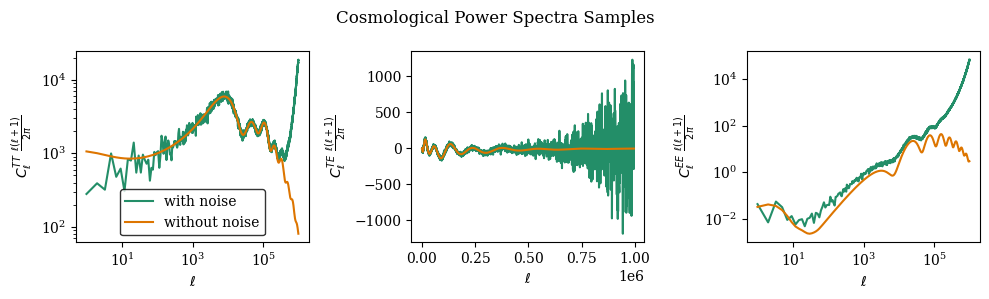

In [39]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.suptitle('Cosmological Power Spectra Samples')
ax1.plot(ells,noise(obs)['TT']*ells, c=green1,label='with noise')
ax1.plot(ells,(obs['TT']-Nltt)*ells,c=orange1, label='without noise')
ax1.legend()
ax1.set_yscale('log');
ax1.set_xscale('log')
ax1.set_xlabel('$\\ell$')
ax1.set_ylabel('$C_{\\ell}^{TT}~\\frac{\\ell(\\ell+1)}{2\pi}$')
ax2.plot(ells, noise(obs)['TE']*ells, c=green1)
ax2.plot(ells, obs['TE']*ells,c=orange1)
ax2.set_xlabel('$\\ell$')
ax2.set_ylabel('$C_{\\ell}^{TE}~\\frac{\\ell(\\ell+1)}{2\pi}$')
#ax2.set_xscale('log')
#ax2.set_yscale('log')
ax3.plot(ells,noise(obs)['EE']*ells,c=green1)
ax3.plot(ells,(obs['EE']-Nlee)*ells,c=orange1)
ax3.set_ylabel('$C_{\\ell}^{EE}~\\frac{\\ell(\\ell+1)}{2\pi}$')
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_xlabel('$\\ell$');
if LOAD==False: plt.savefig('TTTEEE_sample.png',dpi=500)

In [40]:
%%time
noise(obs)

CPU times: user 4.9 ms, sys: 2.91 ms, total: 7.8 ms
Wall time: 6.77 ms


{'TT': array([1.29766190e+03, 1.76123034e+03, 1.97678474e+02, ...,
        1.90629519e-02, 1.90429961e-02, 1.84722518e-02]),
 'EE': array([0.01116346, 0.03469353, 0.00763084, ..., 0.06665884, 0.06723371,
        0.06902773]),
 'TE': array([ 2.92750872e+00,  6.02734576e+00,  8.28646397e-01, ...,
         1.00355009e-03, -6.05694979e-04, -7.56698628e-04])}

now generate reasonable prior using Fisher analysis. Start by defining finite derivative

In [41]:
def finiteD(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=simulator(parr)
    m2=simulator(parr2)
    output=[]
    for kk in ['TT','EE','TE']:
        output.append((m1[kk]-m2[kk])/(pl[k]*(2*eps)))
    return np.ravel(output)

In [42]:
#this is "exact" version of log-likelihood
def chi2(fid, test):
    detTestL=test['TT']*test['EE']-test['TE']**2
    detFidL=fid['TT']*fid['EE']-fid['TE']**2
    #print(test['TT'][0], test['EE'][0], test['TE'][0])
    #print(fid['TT'][0], fid['EE'][0], fid['TE'][0])
    #print(detTestL[0])
    #print(detFidL[0])
    mix=fid['TT']*test['EE']+test['TT']*fid['EE']-2*fid['TE']*test['TE']
    res=np.sum(fsky*(2*ell+1)*(mix/detTestL+np.log(detTestL/detFidL)-2))
    return res
def lnL(fid,test):
    return -0.5*chi2(fid,test)

In [43]:
#use this as consistency check for fisher 
def finiteD2LNL(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=simulator(parr)
    m2=simulator(parr2)
    m0=simulator(pl)
    return (lnL(m0,m1)+lnL(m0,m2)-2*lnL(m0,m0))/(pl[k]*eps)**2

In [44]:
f00=finiteD2LNL(0)

as a check, the following should be close to 1

In [66]:
-F[0][0]/f00

0.9998582915023737

compute derivatives and Fisher matrix

In [45]:
ders=[finiteD(i) for i in range(6)]

In [ ]:
F=np.zeros((6,6))
for i in range(6):
    for j in range(6):
        d1=ders[i]
        if i != j: 
            d2=ders[j]
        else: 
            d2=d1
        term1=np.dot(d1,np.matmul(icovmat,d2))
        F[i,j]=term1

In [47]:
Finv=np.linalg.inv(F)

In a Fisher (i.e. Gaussian) approximation $\sigma_i$ is given by $\sqrt{(F^{-1})_{ii}}$ 

In [48]:
sigss=[]
for i in range(6): sigss.append(np.sqrt(Finv[i,i]));

In [49]:
sigss

[0.00015421594746486337,
 0.00141918642761579,
 0.0003323580629839107,
 0.008657057005849051,
 0.003970490256904045,
 0.00427804661869904]

define uniform prior with $\theta\in [\theta_0-5\sigma,\theta_0+5\sigma]$. For zooming demonstration use $10\sigma$ (that's really wide, what about 8$\sigma$?)

In [50]:
def uv(u):
    offsets=np.array(pl)
    scales=np.array([5*sigss[i] for i in range(len(pl))])
    #scales=np.array([8*sigss[i] for i in range(len(pl))])
    return 2*(u-0.5)*scales+offsets

In [51]:
prior=swyft.Prior.from_uv(uv, 6)

instantiate various swyft objects

In [52]:
sim=swyft.Simulator(simulator, sim_shapes={'TT':[2499], 'TE':[2499],'EE':[2499]})

In [53]:
#store=swyft.DirectoryStore(list(par.keys()), simulator=sim, path='cacheTTTEEE.zarr')
store=swyft.DirectoryStore(['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s','n_s', 'tau_reio'], simulator=sim, path='/var/scratch/aecole/TTTEEElm2500.zarr')

In [54]:
from swyft.networks import OnlineNormalizationLayer
import torch.nn.functional as F
class HeadLow(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 15
        #self.l = torch.nn.Linear(7497-58, 10)
        self.l = torch.nn.Linear(7497, 10)
        self.l2 = torch.nn.Linear(98,5)
        self.onl_f = OnlineNormalizationLayer(torch.Size([7497]))
        self.onl_f2 = OnlineNormalizationLayer(torch.Size([98]))
        #self.Ells = torch.tensor(ells, dtype=torch.float32).to('cuda')

    def forward(self, obs):
        x = torch.cat((obs['TT'][:,49:], obs['EE'][:,49:], obs['TE']), axis=1)
        x1 = torch.sqrt(torch.cat((obs['TT'][:,:49],
                        obs['EE'][:,:49]), axis=1))
        x=torch.cat((x,x1),axis=1)
        x1=torch.sqrt(x1)
        x=self.onl_f(x)
        x1=self.onl_f2(x1)
        nbatch = len(obs)
        x = self.l(x)
        x1=self.l2(x1)

        return torch.cat((x,x1),axis=1)
        #return x

In [55]:
from swyft.networks import OnlineNormalizationLayer
class HeadLinear(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 20
        self.l = torch.nn.Linear(7497, 20)
        self.onl_f = OnlineNormalizationLayer(torch.Size([7497]))

    def forward(self, obs):
        x = torch.cat((obs["TT"], obs['EE'],obs['TE']), axis=1)
        x=self.onl_f(x)

        x = self.l(x)
        return x

In [56]:
partitions=[i for i in range(len(pl))]

In [57]:
from dask.diagnostics import ProgressBar

In [58]:
import logging
logger = logging.getLogger()
logging.basicConfig(level=logging.DEBUG, format="%(message)s")
logger.setLevel(logging.DEBUG)

In [59]:
dataset = swyft.Dataset(5000, prior, simhook = noise, store = store)
if LOAD==False: dataset.simulate()

DEBUG:root:Cache locked
DEBUG:root:Cache unlocked
DEBUG:root:No simulations required.


In [60]:
post = swyft.Posteriors(dataset)

start by checking 1-dimensional marginals

In [61]:
post.infer([0,1,2,3,4,5], device = 'cuda', head = HeadLow,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `HeadLow`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'TT': torch.Size([2499]), 'EE': torch.Size([2499]), 'TE': torch.Size([2499])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(15, [(0,), (1,), (2,), (3,), (4,), (5,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 6.593
DEBUG:root:validation loss = 5.987
DEBUG:root:validation loss = 5.782
DEBUG:root:validation loss = 5.654
DEBUG:root:validation loss = 5.673
DEBUG:root:validation loss = 5.471
DEBUG:ro

In [62]:
sampsSW = post.sample(100000, obs2)

In [63]:
names=['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s','n_s', 'tau_reio']

In [64]:
#rescale to compare to MCMC chain
sampsSW['params'][:,0]*=100

Removed no burn in
omega_b = 2.241\pm 0.015 10^{-2}\omega{}_{b } = 2.240\pm 0.015
Removed no burn in
omega_cdm = 0.1200\pm 0.0013 \omega{}_{cdm } = 0.1200\pm 0.0014
Removed no burn in
100theta_s = 1.04112\pm 0.00033 100\theta{}_{s } = 1.04110\pm 0.00033
Removed no burn in
ln10^{10}A_s = 3.0756^{+0.0082}_{-0.0094} ln10^{10}A_{s } = 3.0764^{+0.0080}_{-0.0095}
Removed no burn in
n_s = 0.9655\pm 0.0040 n_{s } = 0.9651\pm 0.0040
Removed no burn in
tau_reio = 0.0544^{+0.0037}_{-0.0046} \tau{}_{reio } = 0.0546^{+0.0039}_{-0.0047}


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


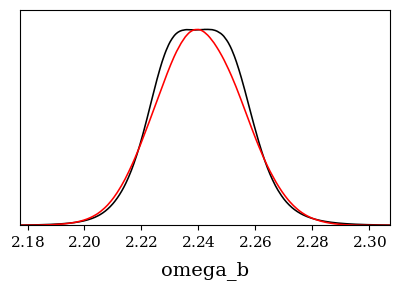

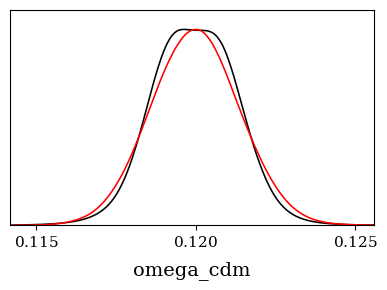

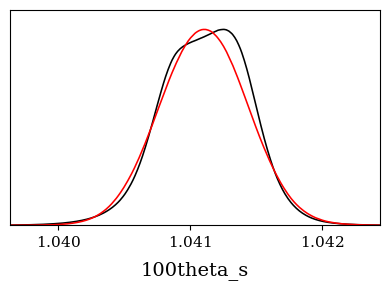

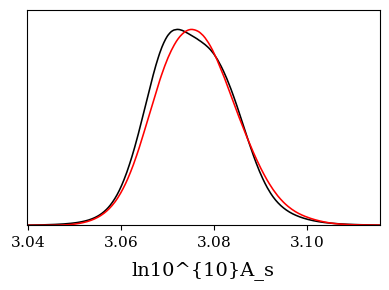

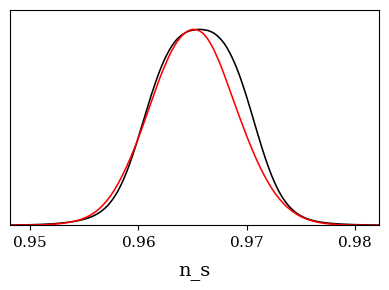

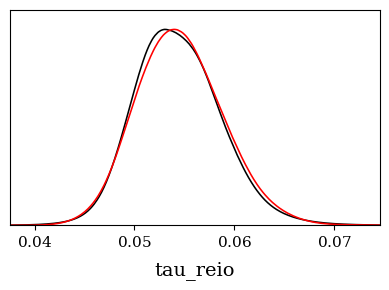

In [73]:
logger.setLevel(logging.INFO)
constr=[]
for j in [0,1,2,3,4,5]:
    samSWYFT= MCSamples(samples=sampsSW['params'], names=names, weights=sampsSW['weights'][(j,)])
    print(samSWYFT.getInlineLatex(names[j],limit=1),SSS.getInlineLatex(names[j],limit=1))
    constr.append((samSWYFT.getInlineLatex(names[j],limit=1),SSS.getInlineLatex(names[j],limit=1)))
    g = plots.get_single_plotter(width_inch=4)
    g.plot_1d([samSWYFT, SSS], names[j], normalized=False)
logger.setLevel(logging.DEBUG)

now train full 2d posterior

In [37]:
post.infer(swyft.utils.parameters._corner_params(partitions), device = 'cuda', head = HeadLow,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `HeadLow`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'TT': torch.Size([2499]), 'EE': torch.Size([2499]), 'TE': torch.Size([2499])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(15, [(0,), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1,), (1, 2), (1, 3), (1, 4), (1, 5), (2,), (2, 3), (2, 4), (2, 5), (3,), (3, 4), (3, 5), (4,), (4, 5), (5,)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 19.75
DEBUG:root:validation loss = 17.67
DEBUG:root:validation loss =

In [38]:
samples=post.sample(100000,obs2)

In [47]:
names=['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s','n_s', 'tau_reio']

In [49]:
samples['params'][:,0]*=100

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the f

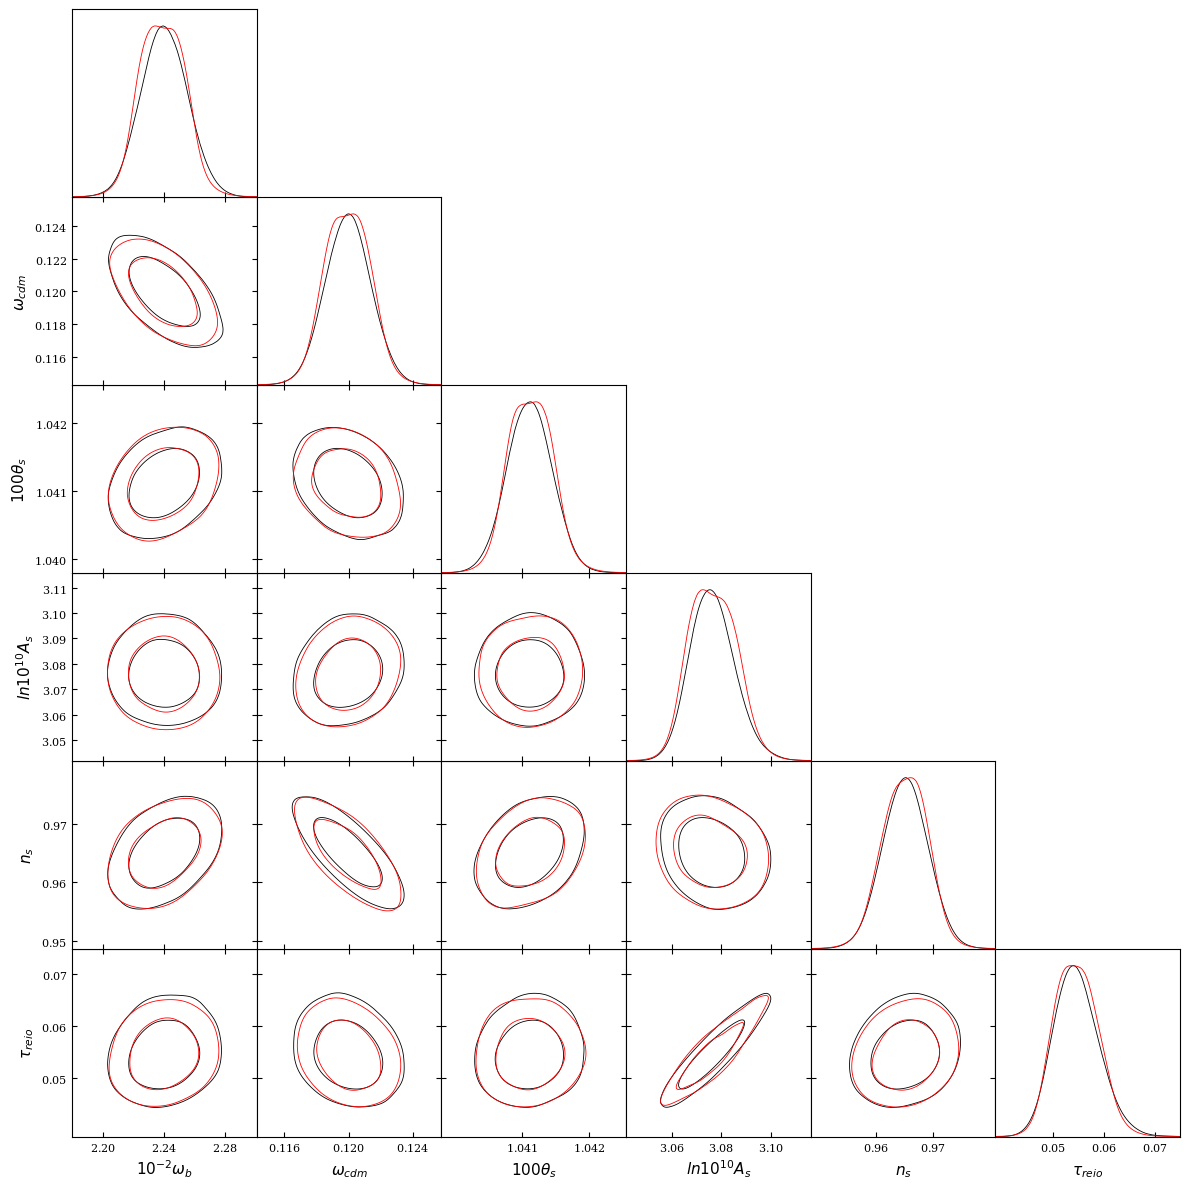

In [50]:
g = plots.get_subplot_plotter()
logger.setLevel(logging.INFO)
triangle_plot(g,[SSS], filled=False)
logger.setLevel(logging.DEBUG)

In [74]:
#Ben's rejection sampling algorithm for sending him samples
def rejection_sample(
        POST,
        N,
        obs,
        excess_factor = 100,
        maxiter= 1000,
        device=None,
        n_batch=10_000,
    ):
        """Samples from each marginal using rejection sampling.
        Args:
            N (int): number of samples in each marginal to output
            obs (dict): target observation
            excess_factor (int, optional): N_to_reject = excess_factor * N . Defaults to 100.
            maxiter (int, optional): maximum loop attempts to draw N. Defaults to 1000.
        Returns:
            Dict[str, np.ndarray]: keys are marginal tuples, values are samples
        Reference:
            Section 23.3.3
            Machine Learning: A Probabilistic Perspective
            Kevin P. Murphy
        """
        weighted_samples = POST.sample(
            N=10 * excess_factor * N, obs=obs,
        )
        maximum_log_likelihood_estimates = {
            k: np.log(np.max(v)) for k, v in weighted_samples["weights"].items()
        }
        param_tuples = set(weighted_samples["weights"].keys())
        collector = {k: [] for k in param_tuples}
        out = {}

        # Do the rejection sampling.
        # When a particular key hits the necessary samples, stop calculating on it to reduce cost.
        # Send that key to out.
        counter = 0
        remaining_param_tuples = param_tuples
        while counter < maxiter:
            # Calculate chance to keep a sample
            log_prob_to_keep = {
                pt: np.log(weighted_samples["weights"][pt])
                - maximum_log_likelihood_estimates[pt]
                for pt in remaining_param_tuples
            }

            # Draw and determine if samples are kept
            to_keep = {
                pt: np.less_equal(np.log(np.random.rand(*v.shape)), v)
                for pt, v in log_prob_to_keep.items()
            }
            # Collect samples for every tuple of parameters, if there are enough, add them to out.
            for param_tuple in remaining_param_tuples:
                kept_all_params = weighted_samples["params"][to_keep[param_tuple]]
                kept_params = kept_all_params[..., param_tuple]
                collector[param_tuple].append(kept_params)
                concatenated = np.concatenate(collector[param_tuple])[:N]
                if len(concatenated) == N:
                    out[param_tuple] = concatenated

            # Remove the param_tuples which we already have in out, thus not to calculate for them anymore.
            for param_tuple in out.keys():
                if param_tuple in remaining_param_tuples:
                    remaining_param_tuples.remove(param_tuple)

            if len(remaining_param_tuples) > 0:
                weighted_samples = POST.sample(
                    N=excess_factor * N, obs=obs,
                )
            else:
                return out
            counter += 1
        warn(
            f"Max iterations {maxiter} reached there were not enough samples produced in {remaining_param_tuples}."
        )
        return out

In [62]:
%%time
if LOAD==False:
    rejection_samples = rejection_sample(post,
                25000, 
                obs2,
                excess_factor=10,
                maxiter=10000,
            )
    torch.save(rejection_samples, '/var/scratch/aecole/CMNREsamples.pt')

CPU times: user 5min 48s, sys: 1min 45s, total: 7min 33s
Wall time: 7min 33s


now train joint (i.e. NRE)

In [72]:
post2 = swyft.Posteriors(dataset)

In [73]:
post2.infer([(0,1,2,3,4,5)], device = 'cuda', head = HeadLow,
          train_args={'lr_schedule':[1e-3,3e-4,1e-4],'early_stopping_patience':2,
                     'max_epochs': 50})

DEBUG:root:Initializing swyft.Module with tag `HeadLow`
DEBUG:root:  args = `()`
DEBUG:root:  kwargs = `{'obs_shapes': {'TT': torch.Size([2499]), 'EE': torch.Size([2499]), 'TE': torch.Size([2499])}}`
DEBUG:root:Initializing swyft.Module with tag `DefaultTail`
DEBUG:root:  args = `(15, [(0, 1, 2, 3, 4, 5)])`
DEBUG:root:  kwargs = `{'n_tail_features': 2, 'p': 0.0, 'hidden_layers': [256, 256, 256], 'online_norm': True, 'param_transform': None, 'tail_features': False}`
DEBUG:root:Entering trainloop
DEBUG:root:  combinations = None
DEBUG:root:  batch_size = 32
DEBUG:root:  nworkers = 0
DEBUG:root:  max_epochs = 50
DEBUG:root:  early_stopping_patience = 2
DEBUG:root:  lr_schedule = [0.001, 0.0003, 0.0001]
DEBUG:root:  percent_validation = 0
DEBUG:root:lr: 0.001
DEBUG:root:validation loss = 0.3593
DEBUG:root:validation loss = 0.2131
DEBUG:root:validation loss = 0.2134
DEBUG:root:validation loss = 0.2341
DEBUG:root:lr: 0.0003
DEBUG:root:validation loss = 0.1302
DEBUG:root:validation loss = 0.0

In [75]:
%%time
if LOAD==False:
    rejection_samples = rejection_sample(post2,
                25000, 
                obs2,
                excess_factor=10,
                maxiter=10000,
            )
    torch.save(rejection_samples, '/var/scratch/aecole/NREsamples.pt')

CPU times: user 6min 11s, sys: 17.4 s, total: 6min 28s
Wall time: 6min 28s


In [122]:
samples = post2.sample(100000, obs2)

In [123]:
names=['omega_b', 'omega_cdm', '100theta_s', 'ln10^{10}A_s','n_s', 'tau_reio']

In [124]:
samples['params'][:,0]*=100

Removed no burn in


<ipython-input-170-e39933e674a4>:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('TTTEEE-corner-trainJointKernel-May19.png', dpi=400)
/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title no

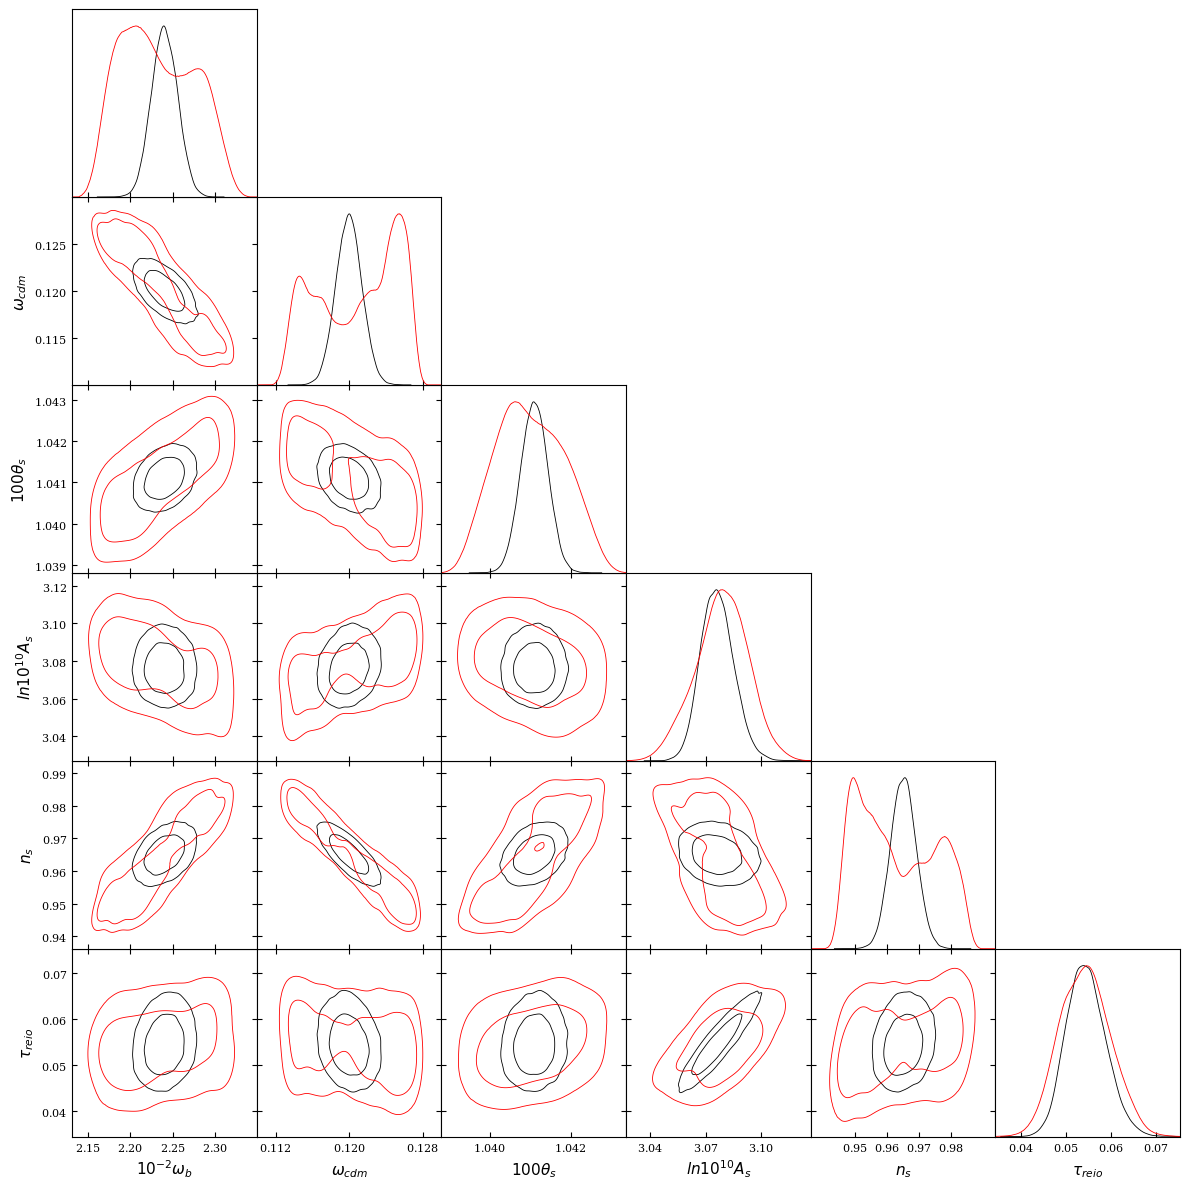

In [170]:
logger.setLevel(logging.INFO)
g = plots.get_subplot_plotter()
g.settings.line_labels =False
g.triangle_plot([SSS,MCSamples(samples=samples['params'], names=names,
                                                    weights=samples['weights'][(0,1,2,3,4,5)],
                                 settings={'mult_bias_correction_order':0})])
plt.savefig('TTTEEE-corner-trainJointKernel-May19.png', dpi=400)
logger.setLevel(logging.DEBUG)

plot small MCMC run

<ipython-input-169-ac0d0f98bc90>:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig('TTTEEE-cornerMCMCsmallGenerous-May19.png', dpi=400)
/var/scratch/aecole/miniconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title not moved
DEBUG:matplotlib.axes._base:top of axes not in the figure, so title no

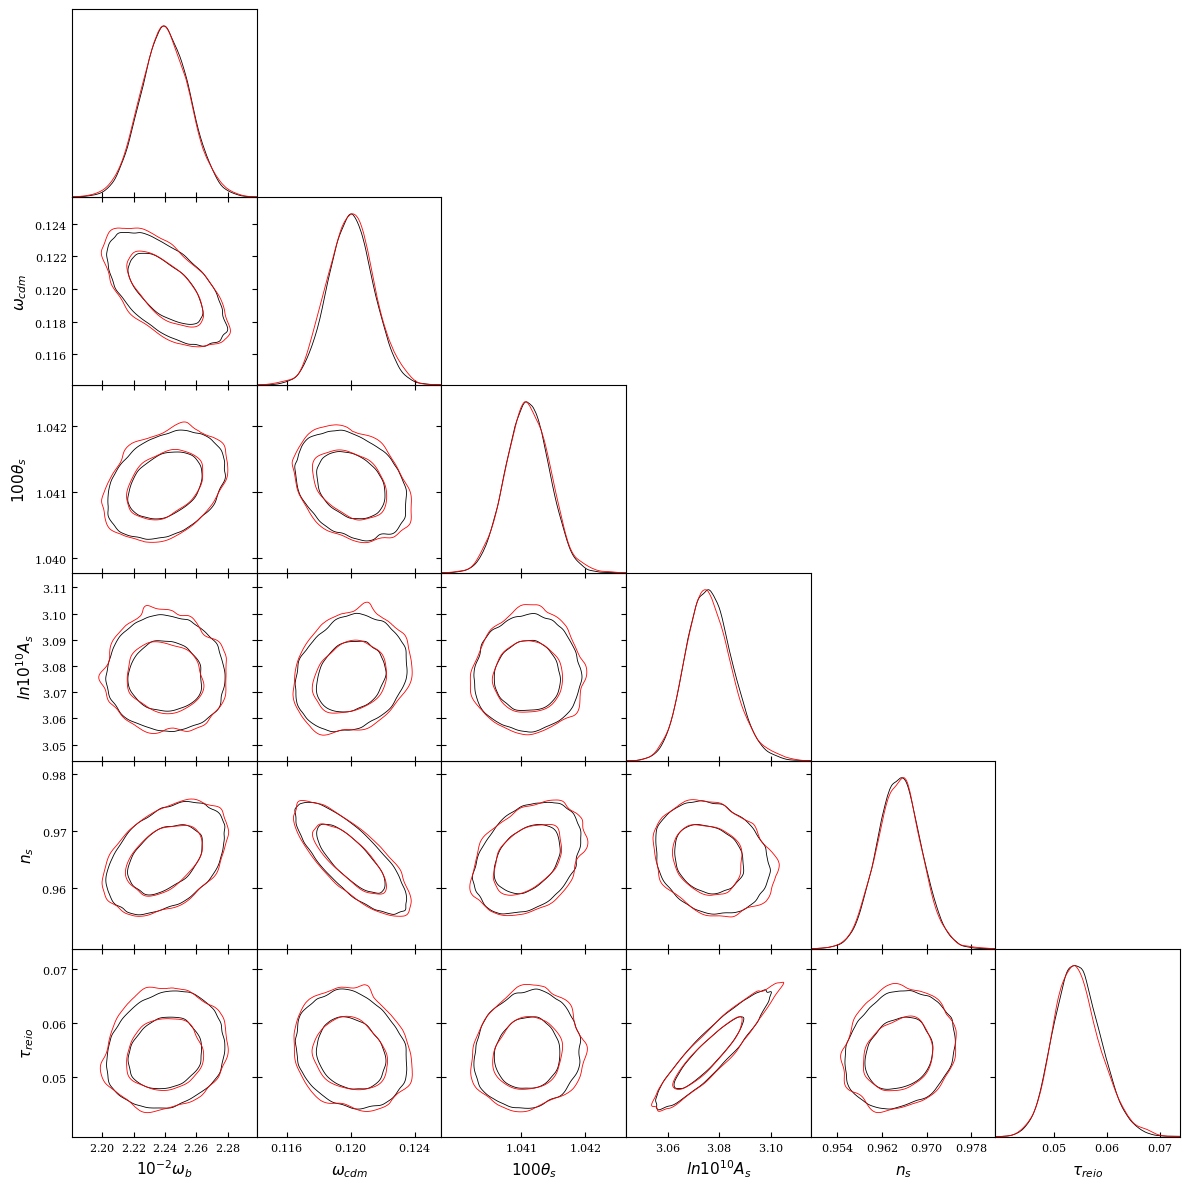

In [169]:
g = plots.get_subplot_plotter()
g.settings.line_labels =False
logger.setLevel(logging.INFO)
g.triangle_plot([SSS,sampMC2], filled=False, legend=False)
plt.savefig('TTTEEE-cornerMCMCsmallGenerous-May19.png', dpi=400)
logger.setLevel(logging.DEBUG)